In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, make_scorer
from xgboost import XGBRegressor
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

In [ ]:
#import models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
wine_data = pd.read_csv("/content/winequalityN.csv")
wine_data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Remove Null Values

In [ ]:
wine_data.isnull().sum()

,0
type,0
fixed acidity,10
volatile acidity,8
citric acid,3
residual sugar,2
chlorides,2
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,9


In [ ]:
from sklearn.impute import KNNImputer

#create a tempory copy of the data set
wine_data_temp= wine_data.copy()

#extract columns that contain at least one missing value
new_column_list = [col for col in wine_data_temp.columns if wine_data_temp[col].isnull().any()]

#update temp dataframe with empty columns.
missing_values_df = wine_data_temp[new_column_list]


In [ ]:
# use knnImpute to impute missing values
knn =KNNImputer(n_neighbors=3)
imputed_values = knn.fit_transform(missing_values_df)

#update tempory dataframe with imputed columns
wine_data_temp[new_column_list] = imputed_values

In [ ]:
#confirm there are no columns with missing values
wine_data_temp.isnull().sum()

,0
type,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0


In [ ]:
#overlay the tempory df over the orginal df with missing values
wine_data = wine_data_temp

## Apply lable encording for categorical column

In [ ]:
wine_data['type'].value_counts()

,count
type,
white,4898
red,1599


In [ ]:
#label encording
wine_data.replace({"type":{'white':0, 'red':1}}, inplace=True)


<ipython-input-54-bd4be644e3ee>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wine_data.replace({"type":{'white':0, 'red':1}}, inplace=True)


# Binarize Dependant column

In [ ]:
wine_data['quality'].value_counts()

,count
quality,
6,2836
5,2138
7,1079
4,216
8,193
3,30
9,5


In [ ]:
wine_data['quality'] = wine_data['quality'].apply(lambda value: 1 if value >=6 else 0)
wine_data['quality'].value_counts()

,count
quality,
1,4113
0,2384


In [ ]:
#split the data

x = wine_data.drop(columns='quality',axis=1)
y = wine_data['quality']

In [ ]:
#split the dataframe

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, stratify=y, random_state=42)
x_train.shape, x_test.shape

((5522, 12), (975, 12))

# Handle clsss imbalace

<Axes: ylabel='count'>

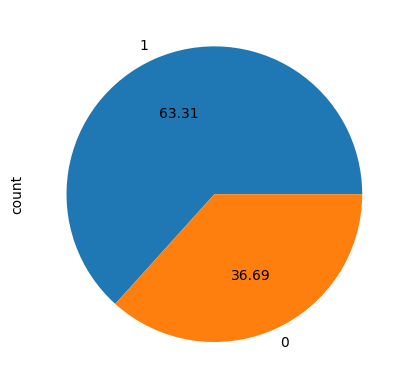

In [ ]:
y_train.value_counts().plot.pie(autopct='%.2f')


In [ ]:
#handle class imbalance by under sampling

rus = RandomUnderSampler(random_state=42)
x_train_res, y_train_res = rus.fit_resample(x_train,y_train)
x_train_res.shape

(4052, 12)

<Axes: ylabel='count'>

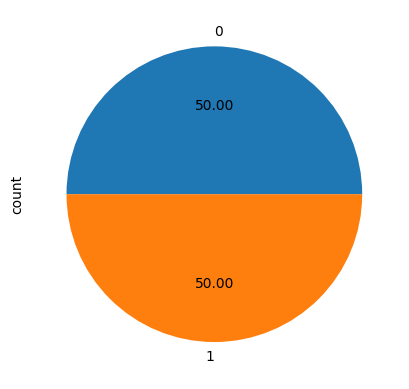

In [ ]:
y_train_res.value_counts().plot.pie(autopct='%.2f')

In [ ]:
y_train_res.value_counts()

,count
quality,
0,2026
1,2026


# standarize

In [ ]:
#standarize
scaler = StandardScaler()

# Fit the scaler on the resampled training data (excluding categorical columns if necessary)
X_train_res_scaled = pd.DataFrame(scaler.fit_transform(x_train_res.drop(columns='type')), columns=x_train_res.drop(columns='type').columns)

# Apply the scaling to the test data (use the scaler fitted on the training data)
X_test_scaled = pd.DataFrame(scaler.transform(x_test.drop(columns='type')), columns=x_test.drop(columns='type').columns)

# If you have categorical columns like 'type', add them back after scaling
X_train_res_scaled['type'] = x_train_res['type'].values
X_test_scaled['type'] = x_test['type'].values

In [ ]:
x_train.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
318,0,5.9,0.30,0.47,7.85,0.030,19.0,133.0,0.99330,3.52,0.43,11.5
1401,0,6.3,0.67,0.48,12.60,0.052,57.0,222.0,0.99790,3.17,0.52,9.3
1595,0,6.4,0.27,0.49,7.30,0.046,53.0,206.0,0.99560,3.24,0.43,9.2
3936,0,5.7,0.23,0.25,7.95,0.042,16.0,108.0,0.99486,3.44,0.61,10.3
4630,0,5.7,0.25,0.32,12.20,0.041,43.0,127.0,0.99524,3.23,0.53,10.4


In [ ]:
x_train.shape, x_test.shape

((5522, 12), (975, 12))

# train model using hyperparameter tuning.

In [ ]:

#create model for RandomForestClassifier

RFC_model = RandomForestClassifier()

param_grid = {
    'n_estimators': [300, 500],            # Further increase n_estimators for model stability
    'max_depth': [10],                     # Keep max_depth at 10 for balanced complexity
    'min_samples_split': [40, 50],         # Maintain regularization for splits
    'min_samples_leaf': [5, 10, 15],       # Test higher values for leaf regularization
    'max_features': ['sqrt'],              # Continue with sqrt for feature selection
    'bootstrap': [True],                   # Bootstrap for stability
    'class_weight': [{0: 4.0, 1:3 }]   # Try custom class weights
}

# Use GridSearchCV with 10-fold cr oss-validation
grid_search = GridSearchCV(
    estimator=RFC_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=6,                                 # Maintain 6-fold cross-validation for balance
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train_res_scaled, y_train_res)

# Output the best parameters
print("Best hyperparameters:", grid_search.best_params_)

#evalute using test data
model_RFC= grid_search.best_estimator_

#evalute using test data
prediction_RFC =  model_RFC.predict(X_test_scaled)

# Print classification report
print(f"\nClassification Report:\n{classification_report(y_test, prediction_RFC)}")

# Calculate training accuracy to check for overfitting
train_predictions = model_RFC.predict(X_train_res_scaled)
training_accuracy = accuracy_score(y_train_res, train_predictions)
print(f"Training Accuracy: {training_accuracy}")
validation_accuracy = accuracy_score(y_test, prediction_RFC)
print(f"Validation Accuracy: {validation_accuracy}")

Fitting 6 folds for each of 12 candidates, totalling 72 fits
Best hyperparameters: {'bootstrap': True, 'class_weight': {0: 4.0, 1: 3}, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 40, 'n_estimators': 300}

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.82      0.71       358
           1       0.87      0.71      0.79       617

    accuracy                           0.75       975
   macro avg       0.75      0.77      0.75       975
weighted avg       0.78      0.75      0.76       975

Training Accuracy: 0.8309476801579467
Validation Accuracy: 0.7538461538461538


LogisticRegression

# Feature Engineering


Feature importances sorted:
                 Feature  Importance
10             sulphates    0.273984
1          fixed acidity    0.137899
7   total sulfur dioxide    0.126030
5              chlorides    0.068250
2       volatile acidity    0.068029
4         residual sugar    0.064583
9                     pH    0.060556
3            citric acid    0.059315
6    free sulfur dioxide    0.054750
8                density    0.044941
0                   type    0.038244
11               alcohol    0.003418

Top 5 most important features: ['sulphates' 'fixed acidity' 'total sulfur dioxide' 'chlorides'
 'volatile acidity']


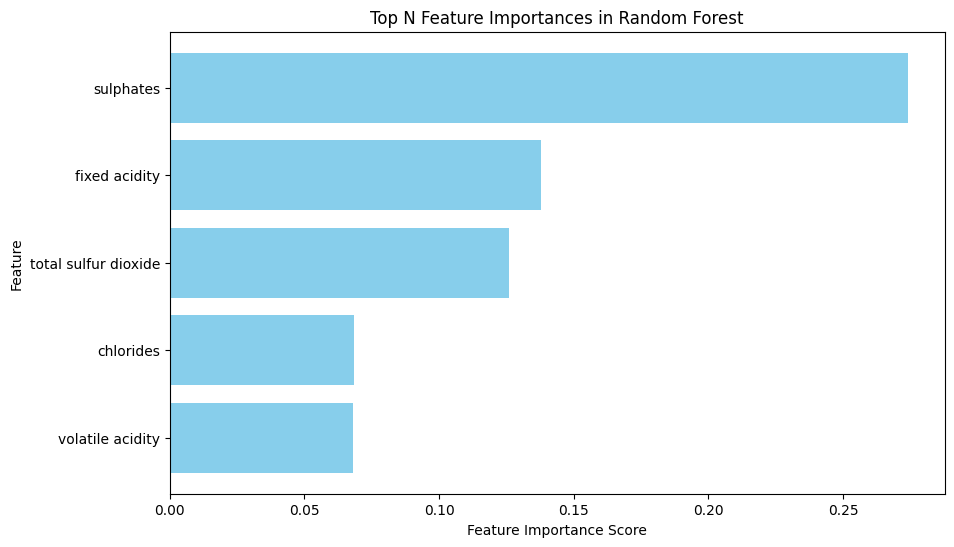

In [ ]:
# Feature importance
importances = model_RFC.feature_importances_

# Get the feature names and importance scores
feature_names = x_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the most important features
print("\nFeature importances sorted:")
print(feature_importance_df)

# Select the top N important features (e.g., top 5)
top_5_features = feature_importance_df['Feature'][:5]
print(f"\nTop 5 most important features: {top_5_features.values}")

# Plot the top N feature importances
plt.figure(figsize=(10, 6))
plt.title("Top N Feature Importances in Random Forest")
plt.barh(top_5_features, feature_importance_df['Importance'][:5], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.show()

# Retrain a model using top 5 features

In [ ]:
X_train_selected = x_train_res[top_5_features]
X_test_selected = x_test[top_5_features]

# Step to add the scaling after selecting the top 5 features:
scaler_top_features = StandardScaler()

# Fit the scaler on the selected top 5 features from the training data
scaler_top_features.fit(X_train_selected)


X_test_selected_scaled = scaler_top_features.transform(X_test_selected)
X_train_selected_scaled = scaler_top_features.transform(X_train_selected)



RFC_model = RandomForestClassifier()

param_grid = {
    'n_estimators': [300, 500],            # Further increase n_estimators for model stability
    'max_depth': [10],                     # Keep max_depth at 10 for balanced complexity
    'min_samples_split': [40, 50],         # Maintain regularization for splits
    'min_samples_leaf': [5, 10, 15],       # Test higher values for leaf regularization
    'max_features': ['sqrt'],              # Continue with sqrt for feature selection
    'bootstrap': [True],                   # Bootstrap for stability
    'class_weight': [{0: 1.0, 1: 2.0 }]   # Try custom class weights
}

# Use GridSearchCV with 10-fold cr oss-validation
grid_search = GridSearchCV(
    estimator=RFC_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=6,                                 # Maintain 6-fold cross-validation for balance
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train_selected_scaled, y_train_res)

# Output the best parameters
print("Best hyperparameters:", grid_search.best_params_)

#evalute using test data
RFC_model_final= grid_search.best_estimator_

#evalute using test data
prediction_RFC =  RFC_model_final.predict(X_test_selected_scaled)

# Print classification report
print(f"\nClassification Report:\n{classification_report(y_test, prediction_RFC)}")

# Calculate training accuracy to check for overfitting
train_predictions = RFC_model_final.predict(X_train_selected_scaled)
training_accuracy = accuracy_score(y_train_res, train_predictions)
print(f"Training Accuracy: {training_accuracy}")
validation_accuracy = accuracy_score(y_test, prediction_RFC)
print(f"Validation Accuracy: {validation_accuracy}")

Fitting 6 folds for each of 12 candidates, totalling 72 fits
Best hyperparameters: {'bootstrap': True, 'class_weight': {0: 1.0, 1: 2.0}, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 40, 'n_estimators': 300}

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.55      0.62       358
           1       0.77      0.88      0.82       617

    accuracy                           0.76       975
   macro avg       0.74      0.71      0.72       975
weighted avg       0.75      0.76      0.75       975

Training Accuracy: 0.743583415597236
Validation Accuracy: 0.7558974358974359


In [ ]:
import joblib
from google.colab import files
joblib.dump(scaler_top_features, 'scaler.pkl')

# Save the scaler
joblib.dump(scaler_top_features, 'scaler.pkl')
# Download the scaler.pkl file
files.download('scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_train_selected_scaled.shape, y_train_res.shape

((4052, 5), (4052,))

In [ ]:
import joblib
# Save the trained model to a file (e.g., 'model.pkl')
joblib.dump(RFC_model_final, 'model.pkl')

# Download the model to your local machine
from google.colab import files
files.download('model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Get user input and predict Resutls

In [ ]:
def get_user_input_and_predict():
    # Define the top 5 features
    top_features = list(top_5_features.values)  # Top 5 selected features

    # Create an empty dictionary to store user inputs
    user_data = {}

    # Collect user input for each top feature
    print("Please provide the following information:")
    for feature in top_features:
        value = float(input(f"Enter {feature}: "))  # Ask user for each top feature input
        user_data[feature] = value  # Store the user input in a dictionary

    # Convert the user input into a DataFrame (1 row, n columns)
    user_input_df = pd.DataFrame([user_data])  # DataFrame with 1 row and top 5 feature columns

    # Scale the user input using the same scaler fitted on the training data
    user_input_scaled = scaler_top_features.transform(user_input_df)  # This returns a NumPy array

    # Make predictions using the trained model
    prediction_proba = RFC_model_final.predict_proba(user_input_scaled)  # Predict probabilities

    # Adjust threshold if needed (e.g., 0.6)
    threshold = 0.5
    prediction = (prediction_proba[:, 1] >= threshold).astype(int)  # Binary classification using threshold

    # Output the prediction
    if prediction == 1:
        print("Prediction: The wine quality is high.")
    else:
        print("Prediction: The wine quality is low.")

    # Display the prediction probabilities for better understanding
    print(f"Prediction probabilities: {prediction_proba}")

    return prediction

In [ ]:
get_user_input_and_predict()

Please provide the following information:
Enter sulphates: 0.61
Enter fixed acidity: 7
Enter total sulfur dioxide: 234
Enter chlorides: 0.29
Enter volatile acidity: 0.046
Prediction: The wine quality is high.
Prediction probabilities: [[0.34510374 0.65489626]]


array([1])

In [ ]:
get_user_input_and_predict()

Please provide the following information:
Enter sulphates: 0.49
Enter fixed acidity: 7.1
Enter total sulfur dioxide: 198
Enter chlorides: 0.35
Enter volatile acidity: 0.055
Prediction: The wine quality is high.
Prediction probabilities: [[0.27848631 0.72151369]]


array([1])